# Evaluating the Model

The document classifier model will need to be evaluated on how well it handles our multiclass classification problem.
We will use this notebook to visualize and quantify the behavior of the model. For brevity, we will assume that each document class
has similar importance for our business case. Note that in a production environment, we would need to consider the financial, social, and ethical
ramifications of document misclasifications. In a real world scenario, it may also be neccesssary to follow more advanced techniques and implement
custom weighted loss functions that expresses numerically the costs of such misclassifications.

For now, we will do the following:
* Instantiate the train model(s) by loading previously saved model checkpoints
* Visualize the confusion matrix of our classifier models
* Calculate the F1 score for each class of document
* Take the model with the highest  F1 score as our champion!

In [68]:
import torch
import utils
import numpy as np
import subprocess
from utils import TEST_FILE_NAME, process_data
from transformers import BertForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [14]:
def load_model_checkpoint(filename):
    model = BertForSequenceClassification.from_pretrained(filename)
    return model

In [44]:
def get_file_length(filename):
    output = subprocess.run(['wc', '-ls', filename], capture_output=True, text=True, check=True)
    line_count = output.stdout
    return line_count

def get_batch_size(filename):
    batch_size = filename.replace(".", "batch_size").replace(":", "batch_size").split("batch_size")[4]
    return int(batch_size)

def get_max_length(filename):
    max_length = filename.replace(".", "max_length").replace(":", "max_length").split("max_length")[8]
    return int(max_length)


def model_results(filename, model):
    batch_size = get_batch_size(filename)
    max_length = get_max_length(filename)
    test_dataloader = process_data(TEST_FILE_NAME, batch_size=batch_size, max_length=max_length)

    with torch.inference_mode():
        y_true, y_pred = [], []
        for X_val, y_val in test_dataloader:
            input_ids = X_val['input_ids'].reshape(
                (X_val['input_ids'].shape[0], X_val['input_ids'].shape[-1]))
            attention_mask = X_val['attention_mask'].reshape(
                (X_val['attention_mask'].shape[0], X_val['attention_mask'].shape[-1]))
            labels = y_val[0]

            _, predictions = model(input_ids=input_ids, token_type_ids=None,
                                attention_mask=attention_mask, labels=labels, return_dict=False)
            y_pred.append(torch.argmax(predictions, dim=1))
            y_true.append(labels)

    return y_true, y_pred

In [12]:
candidate_model= "./logs/bert.batch_size:16.learning_rate:2e-05.max_length:128.mode:normal/checkpoint/epoch:0.step:230.loss:0.1262"

In [66]:
def confusion_matrix_disp(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    fig = ConfusionMatrixDisplay(conf)
    fig.plot()

In [27]:
model = load_model_checkpoint(candidate_model)

In [45]:
y_true, y_pred = model_results(candidate_model, model)

In [46]:
y_true_np = np.concatenate([x.detach().cpu().numpy() for x in y_true], axis=None)
y_pred_np = np.concatenate([x.detach().cpu().numpy() for x in y_pred], axis=None)

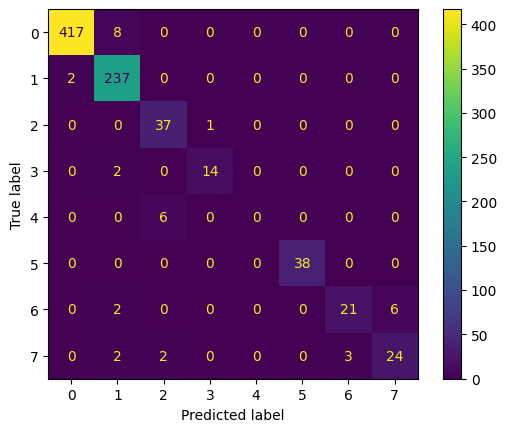

In [67]:
confusion_matrix_disp(y_true_np, y_pred_np)

In [70]:
weighted_f1_score = f1_score(y_true_np, y_pred_np, average='weighted')
print(f"weighted f1 score (weighted by number of examples in each class is {weighted_f1_score}")

weighted f1 score (weighted by number of examples in each class is 0.9548249136467004


Our classifier does relatively well when classifying document types 1, document types 2 and document type 5. 
In a production environment, we will have to improve our classification of document type 4, as it is not able to classify
any of this correctly. However, for the purpose of this excersize, we will stop here!